# Packages

In [1]:
DATA_PATH = "Data/training_set/"

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm
import pickle

from sklearn.model_selection import train_test_split
#from sklearn.utils import class_weight

In [3]:
import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img

2021-10-26 13:11:00.107782: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
# Size and Boarder of the images
n_classes = 4
im_width = 512
im_height = 512
border = 0

# Define Model

In [5]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [6]:
def get_unet(input_img, n_classes = 1,n_filters=16, dropout=0.1, batchnorm=True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size=3, batchnorm=batchnorm)

    #c10 = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    c10 = Conv2D(n_classes, (1, 1), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(c9)
    c10 = Reshape((im_height * im_width, n_classes))(c10)

    outputs = Activation('softmax')(c10)
    
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [7]:
#with strategy.scope():
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_classes = n_classes,n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer="adam", loss= "categorical_crossentropy", metrics=["accuracy"], sample_weight_mode = 'temporal')
callbacks = [
    EarlyStopping(patience=100, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=30, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-fog_pato.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

2021-10-26 13:11:04.879118: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-26 13:11:05.043059: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-26 13:11:05.244681: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-26 13:11:05.244724: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bitfusion-wdc-client01): /proc/driver/nvidia/version does not exist
2021-10-26 13:11:05.245379: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Load Images

In [8]:
ids = next(os.walk(f"{DATA_PATH}image_tiles"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  658


In [9]:
X_color = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
#X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [10]:
n = 0
for i in ids:
    x_color = load_img(f"{DATA_PATH}image_tiles/{i}")
    x_color = np.array(x_color)
    #x = load_img(f"{DATA_PATH}image_tiles/{i}", color_mode = "grayscale")
    #x = np.array(x)
    #x = np.expand_dims(x, axis=-1)
    mask = load_img(f"{DATA_PATH}mask_tiles/{i}", color_mode = "grayscale")
    mask = np.array(mask)
    mask = np.expand_dims(mask, axis=-1)
    X_color[n] = x_color/255.0
    #X[n] = x/255.0
    y[n] = mask/255.0
    n += 1

In [11]:
#from tensorflow.keras.utils import normalize
#X = normalize(X, axis=1)

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
n, h, w,_ = y.shape
y = y.reshape(-1, 1)
y = le.fit_transform(y)

/home/baskayj/venv/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
#####

In [14]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=n_classes)
y = y.reshape(n,h,w,n_classes)

---

In [16]:
def zoom(img_x,img_y,scale_max,seed):
    np.random.seed(seed)
    rn = np.random.rand()
    scale = (1 + rn*scale_max)
    start_x = int(rn*np.shape(img_x)[1])
    start_y = int(rn*np.shape(img_x)[0])
    return cv.resize(img_x,None,fx = scale,fy = scale, interpolation = cv.INTER_CUBIC)[start_y:start_y + np.shape(img_x)[0],start_x:start_x +np.shape(img_x)[1]], (cv.resize(img_y,None,fx = scale,fy = scale, interpolation = cv.INTER_CUBIC)[start_y:start_y + np.shape(img_y)[0],start_x:start_x + np.shape(img_y)[1]] > 0.5).astype(np.float32())

def shift(img_x,img_y,dist_max,seed):
    np.random.seed(seed)
    rn = np.random.rand()
    dir_x = np.random.randint(-1,2)
    dir_y = np.random.randint(-1,2)
    dist = rn*dist_max 
    translation_matrix = np.float32([ [1,0,dir_x*dist], [0,1,dir_y*dist] ])
    return cv.warpAffine(img_x, translation_matrix, np.shape(img_x)[:2], borderMode = cv.BORDER_REPLICATE), (cv.warpAffine(img_y, translation_matrix, np.shape(img_x)[:2],borderMode=cv.BORDER_REPLICATE)>0.5).astype(np.float32())

def rotate(img_x,img_y,seed):
    np.random.seed(seed)
    angle = int(np.random.uniform(-180, 180))
    rotation_matrix = cv.getRotationMatrix2D((int(np.shape(img_x)[1]/2), int(np.shape(img_x)[0]/2)), angle, 1)
    return cv.warpAffine(img_x, rotation_matrix, np.shape(img_x)[:2], borderMode = cv.BORDER_REPLICATE), (cv.warpAffine(img_y, rotation_matrix, np.shape(img_x)[:2],borderMode=cv.BORDER_REPLICATE)>0.5).astype(np.float32())

def flip(img_x,img_y,seed):
    np.random.seed(seed)
    np.random.randint(0,2)
    return cv.flip(img_x, np.random.randint(0,2)), cv.flip(img_y, np.random.randint(0,2)).astype(np.float32())

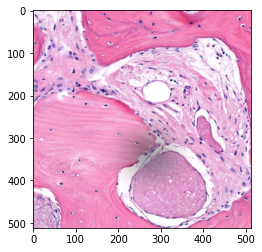

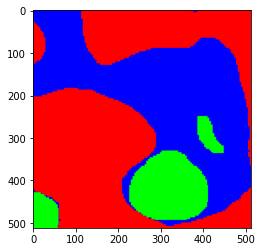

In [17]:
plt.imshow(X_color[36])
plt.show()
plt.imshow(y.reshape(n,h,w,n_classes)[36])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


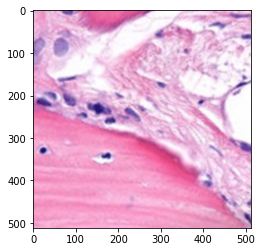

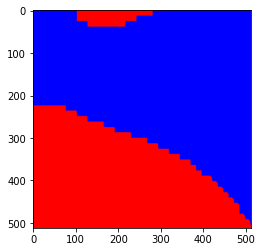

In [18]:
x_t,y_t = zoom(X_color[36],y.reshape(n,h,w,n_classes)[36],3,36)
plt.imshow(x_t)
plt.show()
plt.imshow(y_t)
plt.show()

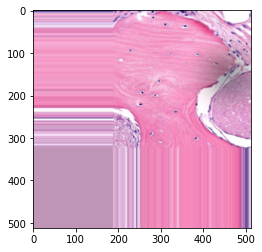

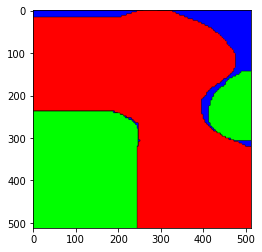

In [19]:
x_t,y_t = shift(X_color[36],y.reshape(n,h,w,n_classes)[36],256,36)
plt.imshow(x_t)
plt.show()
plt.imshow(y_t)
plt.show()

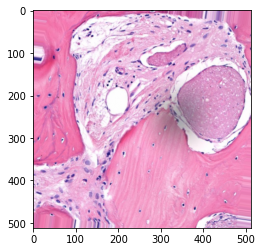

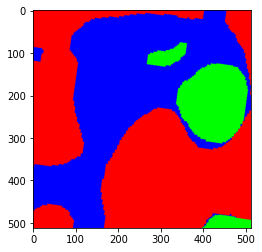

In [20]:
x_t,y_t = rotate(X_color[36],y.reshape(n,h,w,n_classes)[36],36)
plt.imshow(x_t)
plt.show()
plt.imshow(y_t)
plt.show()

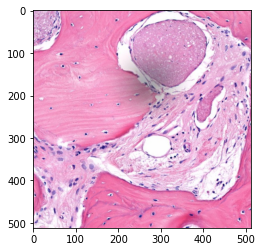

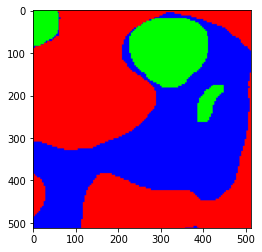

In [21]:
x_t,y_t = flip(X_color[36],y.reshape(n,h,w,n_classes)[36],36)
plt.imshow(x_t)
plt.show()
plt.imshow(y_t)
plt.show()

---

In [15]:
X_transformed = X_color.copy()
y_transformed = y.copy()

"""
for i in range(len(X_color)):
    np.random.seed(i)
    rn = np.random.randint(0,5)
    if rn == 1:
        # Shift
        X_transformed[i], y_transformed[i] = shift(X_color[i], y[i], 256, i)
    elif rn == 2:
        # Zoom
        X_transformed[i], y_transformed[i] = zoom(X_color[i], y[i], 3, i)
    elif rn == 3:
        # Rotate
        X_transformed[i], y_transformed[i] = rotate(X_color[i], y[i], i)
    elif rn == 4:
        # Flip 
        X_transformed[i], y_transformed[i] = flip(X_color[i], y[i], i)
    else:
        # Do nothing
        X_transformed[i], y_transformed[i] = X_color[i], y[i]
"""

y_transformed = y_transformed.reshape(n, h * w, n_classes)
y_flat = np.argmax(y_transformed, axis=2)

In [16]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_transformed, y_transformed, test_size=0.3, random_state=42)
# Splitting the color images the same way
color_train, color_valid,y_train_flat,_ = train_test_split(X_transformed, y_flat, test_size=0.3, random_state=42)

In [17]:
le = LabelEncoder()
y_ind = le.fit_transform(y_flat.reshape(n*h*w*1))
recip_freq = len(y_flat.reshape(n*h*w*1)) / (len(le.classes_) * np.bincount(y_flat.reshape(n*h*w*1)).astype(np.float64))
class_weights = recip_freq[le.transform(np.unique(y_flat))]

In [18]:
print(class_weights)

[0.90508211 8.56982952 5.22135469 0.38656034]


In [19]:
# Normalize them to 1
class_weights = class_weights/sum(class_weights)
print(class_weights)

[0.06000746 0.56818458 0.34617879 0.02562917]


In [20]:
sample_weights = []
for yy in y_train_flat:
    sample_w = []
    for yyy in yy:
        if yyy == 0:
            sample_w.append(class_weights[0])
        elif yyy == 1:
            sample_w.append(class_weights[0])
        else:
            sample_w.append(class_weights[0])
    sample_weights.append(sample_w)
sample_weights=np.array(sample_weights)

# Fit Model

In [21]:
#model.load_weights('model-fog_pato.h5')

In [22]:
#batch_size=16 otherwise colab goes OOM
results = model.fit(color_train, y_train, batch_size=16, epochs=500, callbacks=callbacks,\
                    validation_data=(color_valid, y_valid), sample_weight=sample_weights)

2021-10-20 12:08:11.544517: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-20 12:08:11.544903: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3591560000 Hz


Epoch 1/500
29/29 [==============================] - 216s 7s/step - loss: 0.0587 - accuracy: 0.6334 - val_loss: 2.4950 - val_accuracy: 0.6534

Epoch 00001: val_loss improved from inf to 2.49501, saving model to model-fog_pato.h5
Epoch 2/500
29/29 [==============================] - 210s 7s/step - loss: 0.0299 - accuracy: 0.8941 - val_loss: 5.7054 - val_accuracy: 0.6540

Epoch 00002: val_loss did not improve from 2.49501
Epoch 3/500
29/29 [==============================] - 211s 7s/step - loss: 0.0252 - accuracy: 0.8927 - val_loss: 1.1154 - val_accuracy: 0.6816

Epoch 00003: val_loss improved from 2.49501 to 1.11540, saving model to model-fog_pato.h5
Epoch 4/500
29/29 [==============================] - 206s 7s/step - loss: 0.0209 - accuracy: 0.9178 - val_loss: 0.6336 - val_accuracy: 0.7966

Epoch 00004: val_loss improved from 1.11540 to 0.63361, saving model to model-fog_pato.h5
Epoch 5/500
29/29 [==============================] - 208s 7s/step - loss: 0.0205 - accuracy: 0.9132 - val_loss:

29/29 [==============================] - 212s 7s/step - loss: 0.0068 - accuracy: 0.9568 - val_loss: 0.1867 - val_accuracy: 0.9371

Epoch 00041: val_loss did not improve from 0.13904
Epoch 42/500
29/29 [==============================] - 211s 7s/step - loss: 0.0070 - accuracy: 0.9555 - val_loss: 0.1277 - val_accuracy: 0.9530

Epoch 00042: val_loss improved from 0.13904 to 0.12770, saving model to model-fog_pato.h5
Epoch 43/500
29/29 [==============================] - 212s 7s/step - loss: 0.0064 - accuracy: 0.9591 - val_loss: 0.1873 - val_accuracy: 0.9427

Epoch 00043: val_loss did not improve from 0.12770
Epoch 44/500
29/29 [==============================] - 212s 7s/step - loss: 0.0070 - accuracy: 0.9549 - val_loss: 0.1520 - val_accuracy: 0.9458

Epoch 00044: val_loss did not improve from 0.12770
Epoch 45/500
29/29 [==============================] - 213s 7s/step - loss: 0.0068 - accuracy: 0.9563 - val_loss: 0.1554 - val_accuracy: 0.9498

Epoch 00045: val_loss did not improve from 0.12770


Epoch 00082: val_loss did not improve from 0.12567
Epoch 83/500
29/29 [==============================] - 212s 7s/step - loss: 0.0048 - accuracy: 0.9675 - val_loss: 0.1489 - val_accuracy: 0.9516

Epoch 00083: val_loss did not improve from 0.12567
Epoch 84/500
29/29 [==============================] - 213s 7s/step - loss: 0.0052 - accuracy: 0.9648 - val_loss: 0.2661 - val_accuracy: 0.9313

Epoch 00084: val_loss did not improve from 0.12567
Epoch 85/500
29/29 [==============================] - 212s 7s/step - loss: 0.0050 - accuracy: 0.9659 - val_loss: 0.1758 - val_accuracy: 0.9458

Epoch 00085: val_loss did not improve from 0.12567
Epoch 86/500
29/29 [==============================] - 213s 7s/step - loss: 0.0052 - accuracy: 0.9648 - val_loss: 0.1329 - val_accuracy: 0.9518

Epoch 00086: val_loss did not improve from 0.12567
Epoch 87/500
29/29 [==============================] - 212s 7s/step - loss: 0.0051 - accuracy: 0.9658 - val_loss: 0.1238 - val_accuracy: 0.9550

Epoch 00087: val_loss im

29/29 [==============================] - 213s 7s/step - loss: 0.0031 - accuracy: 0.9793 - val_loss: 0.1298 - val_accuracy: 0.9557

Epoch 00124: val_loss did not improve from 0.12380
Epoch 125/500
29/29 [==============================] - 211s 7s/step - loss: 0.0032 - accuracy: 0.9781 - val_loss: 0.1313 - val_accuracy: 0.9561

Epoch 00125: val_loss did not improve from 0.12380
Epoch 126/500
29/29 [==============================] - 212s 7s/step - loss: 0.0033 - accuracy: 0.9777 - val_loss: 0.1327 - val_accuracy: 0.9559

Epoch 00126: val_loss did not improve from 0.12380
Epoch 127/500
29/29 [==============================] - 212s 7s/step - loss: 0.0032 - accuracy: 0.9780 - val_loss: 0.1322 - val_accuracy: 0.9559

Epoch 00127: val_loss did not improve from 0.12380
Epoch 128/500
29/29 [==============================] - 209s 7s/step - loss: 0.0030 - accuracy: 0.9794 - val_loss: 0.1325 - val_accuracy: 0.9564

Epoch 00128: val_loss did not improve from 0.12380
Epoch 129/500
29/29 [=============

In [23]:
outfile = open(f"{DATA_PATH}train_results.pickle","wb")
pickle.dump(results.history, outfile)
outfile.close()

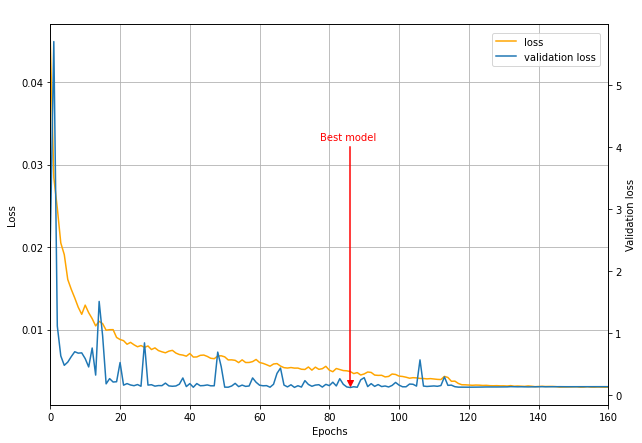

In [63]:
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(10)

ax1 = plt.subplot(1,1,1)
ax1.plot(results.history["loss"], color = "orange", label="loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_xlim((0,160))
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(results.history["val_loss"], label="validation loss")
ax2.plot(np.ones((20))*np.argmin(results.history["val_loss"]), np.linspace(np.min(results.history["val_loss"])+0.08,4,20), marker="", color="r")
ax2.scatter(np.argmin(results.history["val_loss"]),np.min(results.history["val_loss"])+0.08,color = "r",marker = "v")
ax2.set_ylabel("Validation loss")

fig.legend(loc=[0.765,0.85]);
fig.text(0.5,0.65,"Best model",color = "red");

In [ ]:
from sklearn.metrics import accuracy_score
model.load_weights('model-fog_pato.h5')
y_pred = model.predict(X_valid)

In [36]:
accuracy_score(np.argmax(y_valid,axis = 2).reshape(np.shape(y_pred)[0]*np.shape(y_pred)[1]),np.argmax(y_pred,axis=2).reshape(np.shape(y_pred)[0]*np.shape(y_pred)[1]))

0.9596426607382418

# Looking at the Predictions

In [65]:
# Load Weights
model.load_weights('model-fog_pato.h5')

In [66]:
# Prediction
parts = [1,2,3,4,5,6,7,8]
for part in tqdm(parts):
    outfile = open(f"{DATA_PATH}validation/predicted/preds_part_{part}.pickle","wb")
    X_to_pred = X_color[(part-1)*int(len(X_color)/len(parts)):part*int(len(X_color)/len(parts))].copy()
    preds = model.predict(X_to_pred,verbose=0)
    preds = preds.reshape(len(X_to_pred),h,w,n_classes)
    preds_con = np.zeros((len(X_to_pred),h,w,n_classes-1))
    preds_con[:,:,:,0] = preds[:,:,:,0]
    preds_con[:,:,:,1] = preds[:,:,:,1] + preds[:,:,:,2]
    preds_con[:,:,:,2] = preds[:,:,:,3]
    del preds
    preds_con = (preds_con*255).astype(np.uint8)
    pickle.dump(preds_con, outfile)
    outfile.close()
del model
n_classes = n_classes-1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:32<00:00, 11.60s/it]


In [67]:
parts = [1,2,3,4,5,6,7,8]
for part in parts:
    infile = open(f"{DATA_PATH}validation/predicted/preds_part_{part}.pickle","rb")
    preds = pickle.load(infile)
    infile.close()
    for i in tqdm(range(len(preds))):
        preds[i] = cv.bilateralFilter(preds[i],32,64,64)
        
    outfile = open(f"{DATA_PATH}validation/smoothed/preds_part_{part}.pickle","wb")
    pickle.dump(preds, outfile)
    outfile.close()

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:30<00:00,  2.65it/s]


In [68]:
y_con = np.zeros((n,h,w,n_classes))
y_con[:,:,:,0] = y[:,:,:,0]
y_con[:,:,:,1] = y[:,:,:,1] + y[:,:,:,2]
y_con[:,:,:,2] = y[:,:,:,3]

In [98]:
def plot_sample(color, y, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(color))
    
    part_idx = int(ix/82)
    idx = ix%82
    infile = open(f"{DATA_PATH}validation/smoothed/preds_part_{part_idx+1}.pickle","rb")
    pred = (pickle.load(infile)/255)[idx]
    infile.close()
    
    binary_pred = to_categorical(pred.argmax(axis=2), num_classes=n_classes)
    
    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(color[ix])
    if has_mask:
        if max(y[ix][:,:,0].squeeze().flatten()) > 0:
            c_red = ax[0].contour(y[ix][:,:,0].squeeze(), colors='red', levels=[0.5])
            c_red.collections[0].set_label("bone tissue")
        if max(y[ix][:,:,1].squeeze().flatten()) > 0:
            c_green = ax[0].contour(y[ix][:,:,1].squeeze(), colors='green', levels=[0.5])
            c_green.collections[0].set_label("bone graft mat.")
    ax[0].set_title('Original')
    ax[0].legend()
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    
    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)

    ax[2].imshow(pred.squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Mask Predicted')
    ax[2].get_xaxis().set_visible(False)
    ax[2].get_yaxis().set_visible(False)
    
    ax[3].imshow(binary_pred.squeeze(), vmin=0, vmax=1)
    ax[3].set_title('Mask Predicted smoothed & thresholded')
    ax[3].get_xaxis().set_visible(False)
    ax[3].get_yaxis().set_visible(False)
    plt.show()

## Samples

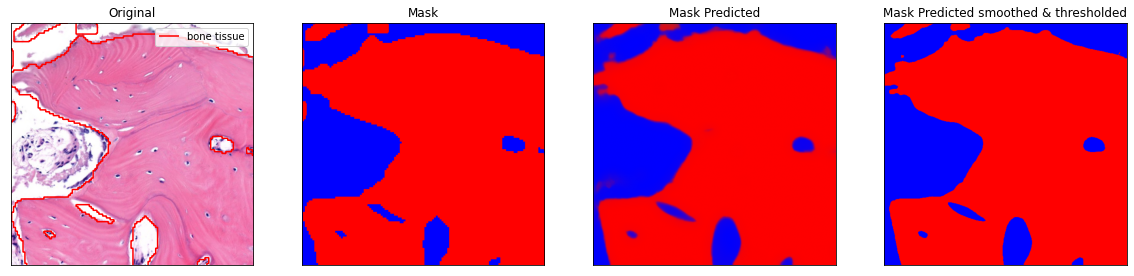

In [101]:
plot_sample(X_color, y_con.reshape(n, h, w, n_classes))

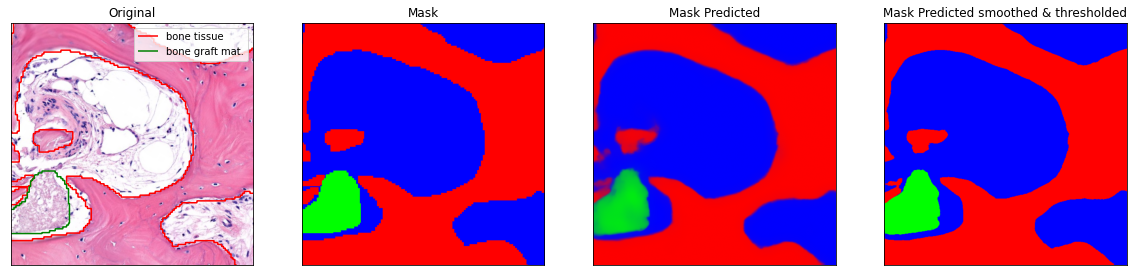

In [106]:
plot_sample(X_color, y_con.reshape(n, h, w, n_classes))

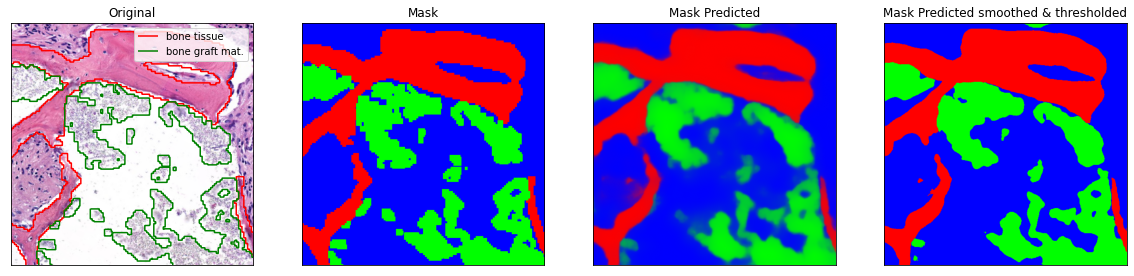

In [108]:
plot_sample(X_color, y_con.reshape(n, h, w, n_classes))

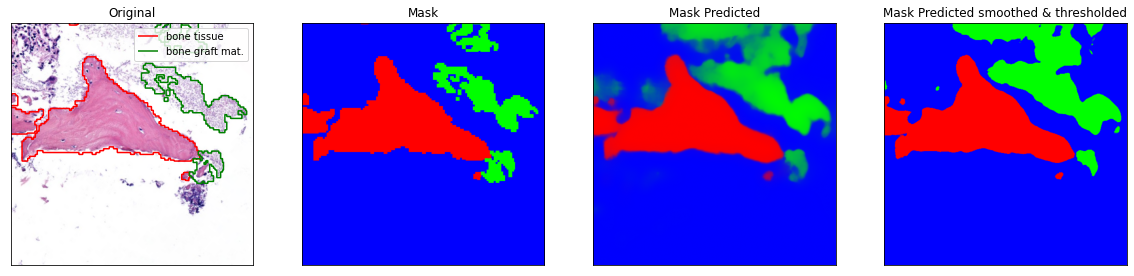

In [109]:
plot_sample(X_color, y_con.reshape(n, h, w, n_classes))

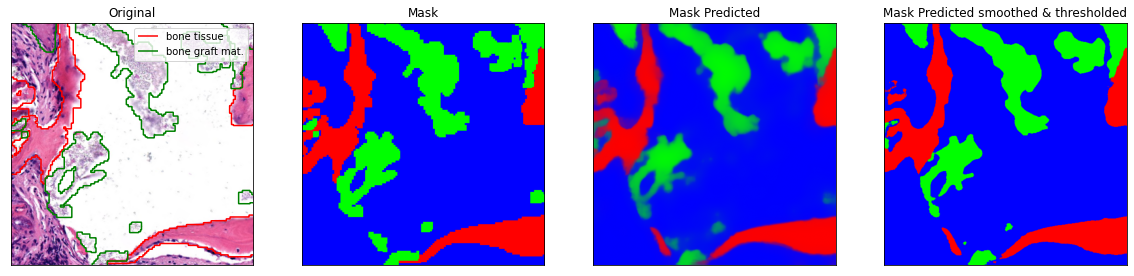

In [112]:
plot_sample(X_color, y_con.reshape(n, h, w, n_classes))

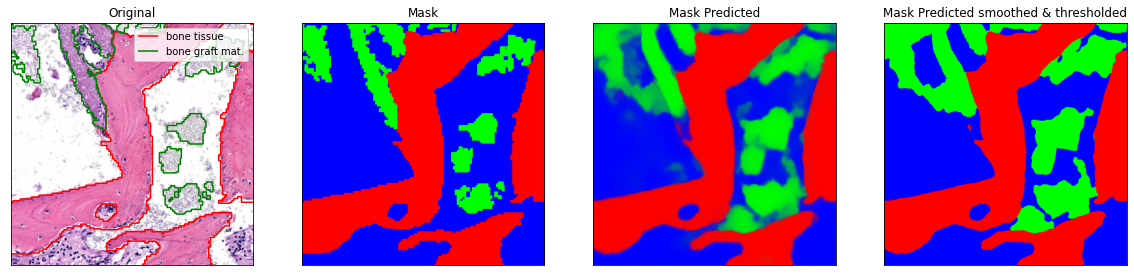

In [114]:
plot_sample(X_color, y_con.reshape(n, h, w, n_classes))

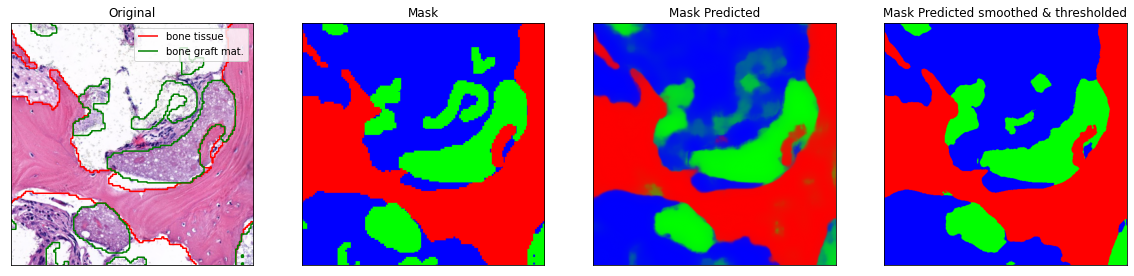

In [119]:
plot_sample(X_color, y_con.reshape(n, h, w, n_classes))

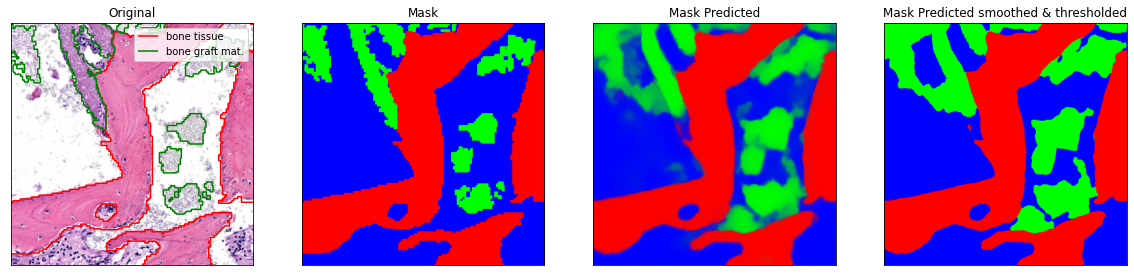

In [120]:
plot_sample(X_color, y_con.reshape(n, h, w, n_classes))

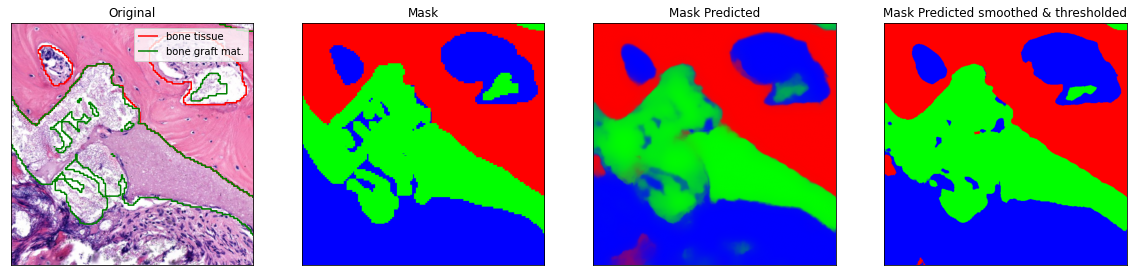

In [123]:
plot_sample(X_color, y_con.reshape(n, h, w, n_classes))

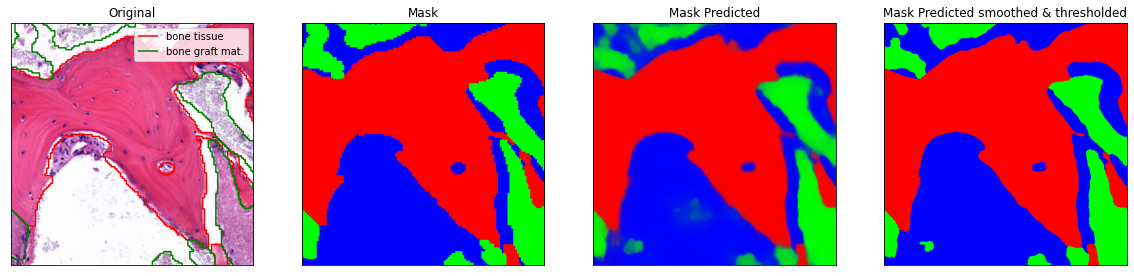

In [126]:
plot_sample(X_color, y_con.reshape(n, h, w, n_classes))

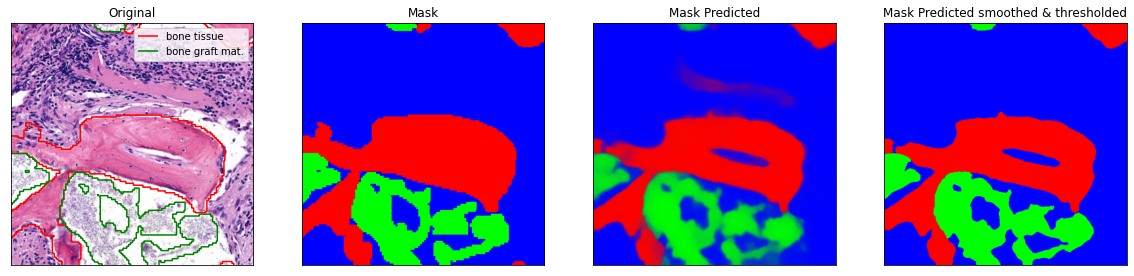

In [129]:
plot_sample(X_color, y_con.reshape(n, h, w, n_classes))

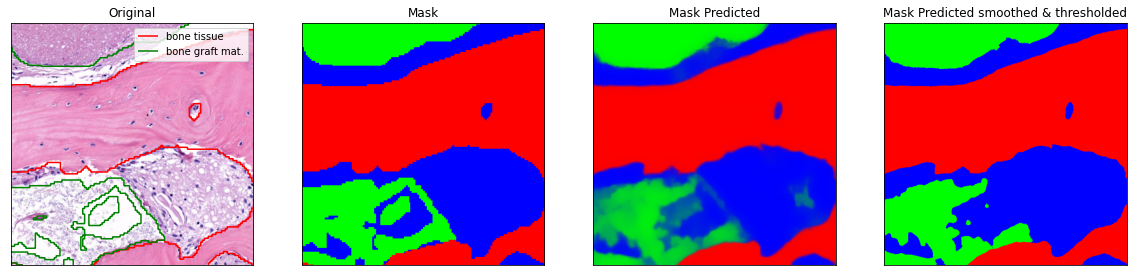

In [134]:
plot_sample(X_color, y_con.reshape(n, h, w, n_classes))

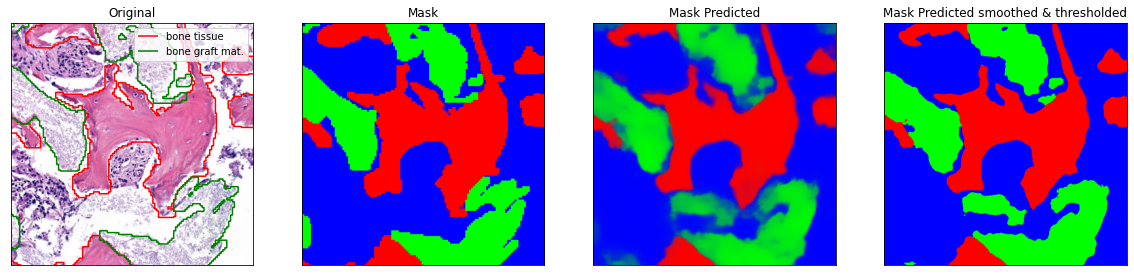

In [148]:
plot_sample(X_color, y_con.reshape(n, h, w, n_classes))

# Predict and Save

In [15]:
model.load_weights('model-fog_pato.h5')
n_classes = 3

In [16]:
preds = model.predict(X_color, verbose=1).reshape(n, h, w, n_classes+1)
preds_con = np.zeros((n,h,w,n_classes))
preds_con[:,:,:,0] = preds[:,:,:,0]
preds_con[:,:,:,1] = preds[:,:,:,1] + preds[:,:,:,2]
preds_con[:,:,:,2] = preds[:,:,:,3]
del preds

#Save
c = 0
for i in ids:
    cv.imwrite(f"{DATA_PATH}predicted_tiles/{i}",cv.cvtColor((preds_con[c]*255).astype(np.uint8), cv.COLOR_RGB2BGR))
    c += 1

21/21 [==============================] - 34s 2s/step
